# CLASSIFICATION TASK WITH LOGISTIC REGRESSION

by ChunkDevs (Group 1)

One of the models that have been chosen for our project baseline is **Logistic Regression** which, in natural language processing, is one of the baseline supervised machine learning algorithms for classification. 

In order to transform the tweets in a input data that is compatible with this model, we will try two different vectorization techniques: **Bag Of Words** (**BOW**) and **Term Frequency - Inverse Document Frequency** (**TF-IDF**). We will use `CountVectorizer` and `TfidfVectorizer` classes from `sklearn.feature_extraction.text `.

We will try BOW and TF-IDF for both binary and multiclass classification task, therefore, we will use the class `ChunkDevs_GridTrainer` of our library to select the best hyperparameteres with the gridsearch, validate our model and finally predict on the raw unprocessed tweets of the test set. 

In [1]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from _chunkdevs.models import ChunkDevs_GridTrainer, ModelHandler
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif

2024-06-24 18:17:30.123320: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 18:17:30.342558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 18:17:32.645243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATA LOADING

In [3]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

In [4]:
dev.shape, test.shape

((26268, 5), (2922, 4))

In [5]:
dev.head()

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi,tweet_text_cleaned
0,I was bullied in fourth grade cause my twin li...,age,1,0,i was bullied in fourth grade cause my twin li...
1,I bullied myself for not looking like the othe...,age,1,0,i bullied myself for not looking like the othe...
2,Hijabi lives in a diverse community and joins ...,age,1,0,hijabi lives in a diverse community and joins ...
3,Your amazing me and my son who’s 11 and a aspi...,age,1,0,your amazing me and my son whos 11 and a aspir...
4,I hope all the bitches who bullied girls in hi...,age,1,0,i hope all the bitches who bullied girls in hi...


In [6]:
test.head()

,tweet_text,cyberbullying_type,cyberbullying_type_bin,cyberbullying_type_multi
0,"Concept of 'Dark Power': Like soft power, but ...",age,1,0
1,I want to cyber bully a school board member,age,1,0
2,my school was super chill about it.... unlike ...,age,1,0
3,If that person is a school yard bully won't th...,age,1,0
4,I can't stand his voice or his look. He's a sm...,age,1,0


In [7]:
path_models = os.path.join(root_path, 'outputs', 'models')

RANDOM_STATE = 42

k_fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

<div style="font-size: 18px;">
    
Using the same `RANDOM_STATE` value as the other notebook. For the crossvalidation approach, we decided to split the dev-set into 5 folds and shuffling the examples for each iteration during the gridsearch of the models.    

<br>
</div>

# FEATURES EXTRACTION WITH COUNTVECTORIZER

## BINARY CLASSIFICATION TASK

Additionally, a `CountVectorizer` was set up to transform text data into a matrix of token counts, where each cell represents the count of a a specific word in a particular tweet (Bag of Words).

The hyperparameters are specified in `param_grid`, which consists of a list of dictionaries with two possible combinations of hyperparameters.

In [8]:
model = LogisticRegression(random_state=RANDOM_STATE)
vectorizer = CountVectorizer()


X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_train_bin = vectorizer.fit_transform(X_dev_bin)
X_test_bin = vectorizer.transform(X_test_bin)


param_grid = [
    {'solver': ["liblinear"], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'max_iter' : [100000]},
    {'solver': ["newton-cg", "lbfgs", "sag"], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'max_iter' : [100000]}
]

For the model implementation, we used our class `ChunkDevs_GridTrainer` for training different models using Grid Search with cross-validation.


This are the **attributes** needed for our class:

- `model` : The model to be optimized. (Compatible with NB, LogReg, SVM, and XGB)
- `param_grid` : The model parameter grid to search over.
- `scoring` : The scoring metric to use for evaluation, in all the notebook we used **f1 score for binary** tasks and **accuracy for multiclass** 
- `cv` : The cross-validation strategy (5 folds with shuffling have been used for every model (except for LSTM and transformers )in order to maintain the same procedure)
- `n_jobs` : The number of jobs to run in parallel. (always -1 for enabling parallel use of the processors)
- `grid_search` : The GridSearchCV object after fitting.

This are the **methods** available with our class:

- `train`: Train the model using Grid Search with the provided training data.
- `predict` Make blind predictions using the trained model.
- `get_best_params`Get the best parameters found by Grid Search.
- `get_best_score` Get the best score achieved by Grid Search.
- `get_classification_report` Get the classification report for the test data.
- `get_confusion_matrix` Get the confusion matrix for the test data.
- `save_results` Save the Grid Search results and classification report to a file.

### GRIDSEARCH AND TRAINING

Gridsearch with 5-fold cross-validation and shuffling enabled. After finding the best hyperparameters, we train the model using all the dev-set

For the binary task, the `ChunkDevs_GridTrainer` is initialized with "f1_weighted" as scoring because the dataset has an imbalanced class distribution, with the "not cyberbullying" class being less numerous than the "cyberbullying" class. In such cases, accuracy  can be misleading since a model could achieve high accuracy by simply predicting the majority class.

In [9]:
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)
best_model_logreg_countvect_bin = trainer.train(X_train_bin, y_dev_bin)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'C': 1, 'class_weight': None, 'max_iter': 100000, 'penalty': 'l1', 'solver': 'liblinear'} 



### TESTING PHASE

Testing of the assessed model to the test-set and showing our results

In [10]:
y_pred_bin = trainer.predict(X_test_bin)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_bin, y_test_bin)
print(report)

Classification report for LogisticRegression(random_state=42)
              precision    recall  f1-score   support

           0       0.59      0.54      0.56       487
           1       0.91      0.92      0.92      2435

    accuracy                           0.86      2922
   macro avg       0.75      0.73      0.74      2922
weighted avg       0.86      0.86      0.86      2922



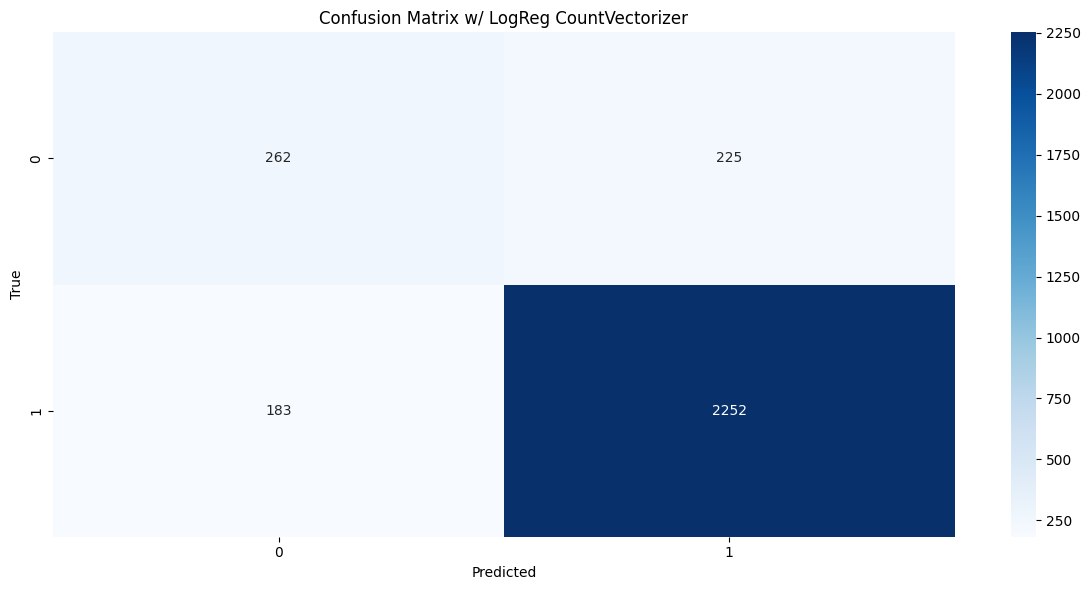

In [11]:
matrix = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ LogReg CountVectorizer')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', '4_cm_logreg_countvect_bin.png'))
plt.show()

<div style="font-size: 20px;">    

Considering the confusion matrix, the logistic regression is able to **correctly classify the cyberbullying class, but not the not-cyberbullying one**. It necessary to consider that the classes are very umbalanced, so we can not rely on the accuracy metric to evaluate the model. For the class 0, we have low values of precision, recall and f1 score.  

<br></div>

### RESULTS SAVING
Saving the results to the appropriate folder

In [12]:
save_path = os.path.join(root_path, 'outputs', 'reports', '2_logreg_countvect.txt')
trainer.save_results(X_test_bin, y_test_bin, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/2_logreg_countvect.txt


## MULTICLASS CLASSIFICATION TASK

In [13]:
X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

X_train_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)


param_grid = [
    {'solver': ["newton-cg", "lbfgs", "sag"], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'max_iter' : [100000]}
]

Another hyperparameter tuning and training for the logistic regression model was conducted for multiclass classification.

In this case, we have chosen "accuracy" as the evaluation metric because the dataset is balanced for the multiclass classification.

### GRIDSEARCH AND TRAINING

Gridsearch with 5-fold cross-validation and shuffling enabled. After finding the best hyperparameters, we train the model using all the dev-set

In [14]:
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_logreg_countvect_multi = trainer.train(X_train_multi, y_dev_multi)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100000, 'penalty': 'l2', 'solver': 'newton-cg'} 



### TESTING PHASE

Testing of the assessed model to the test-set and showing our results

In [15]:
y_pred_multi = trainer.predict(X_test_multi)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_multi, y_test_multi)
print(report)

Classification report for LogisticRegression(random_state=42)
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       487
           1       0.98      0.97      0.98       487
           2       0.91      0.79      0.84       487
           3       0.57      0.63      0.60       487
           4       0.62      0.68      0.65       487
           5       0.97      0.92      0.94       487

    accuracy                           0.83      2922
   macro avg       0.84      0.83      0.83      2922
weighted avg       0.84      0.83      0.83      2922



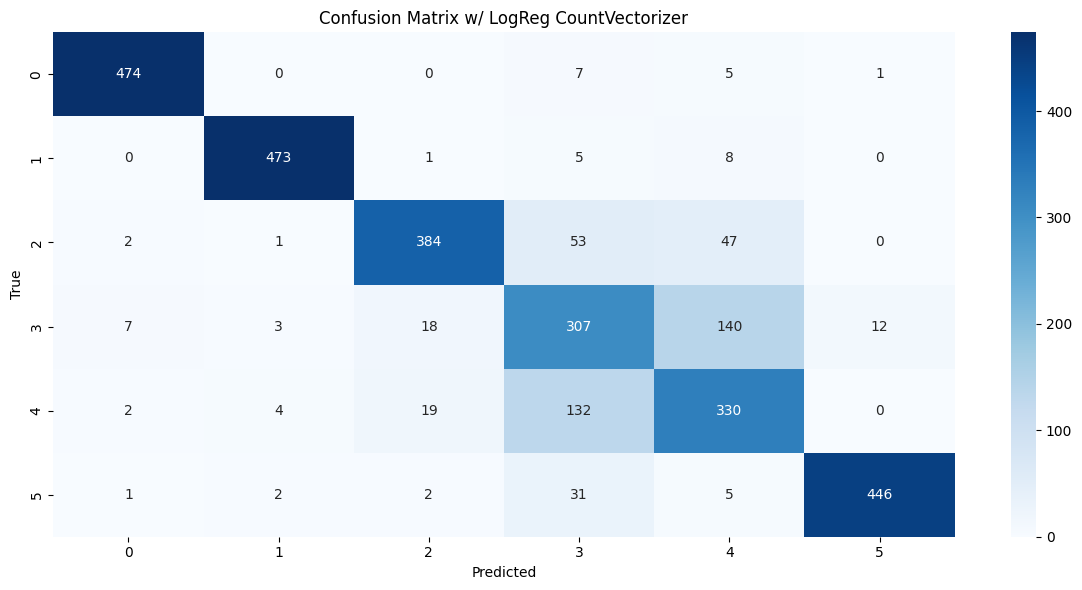

In [16]:
matrix = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ LogReg CountVectorizer')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', '5_cm_logreg_countvect_multi.png'))
plt.show()

<div style="font-size: 20px;">  

Considering the results, this baseline has an **high value of accuracy**. Therefore, we can affirm that for the multiclass task we start with an already **strong baseline**

<br></div>

### RESULTS SAVING
Saving the results to the appropriate folder

In [17]:
save_path = os.path.join(root_path, 'outputs', 'reports', '2_logreg_countvect.txt')
trainer.save_results(X_test_multi, y_test_multi, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/2_logreg_countvect.txt


# FEATURES EXTRACTION WITH TF-IDF

The second technique used as feature for our baseline is `TF-IDF`, that converts text data into numerical vectors by measuring the importance of a word in a document relative to a collection of documents, considering both its frequency in the document and its rarity across all documents.

## BINARY CLASSIFICATION TASK

In [18]:
vectorizer = TfidfVectorizer()


X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_train_bin = vectorizer.fit_transform(X_dev_bin)
X_test_bin = vectorizer.transform(X_test_bin)


param_grid = [
    {'solver': ["liblinear"], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'max_iter' : [100000]},
    {'solver': ["newton-cg", "lbfgs", "sag"], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'max_iter' : [100000]}
]

### GRIDSEARCH AND TRAINING

In [19]:
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)
best_model_logreg_tfidf_bin = trainer.train(X_train_bin, y_dev_bin)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

/home/m.sanna21/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'C': 10, 'class_weight': None, 'max_iter': 100000, 'penalty': 'l2', 'solver': 'lbfgs'} 



### TESTING PHASE

In [20]:
y_pred_bin = trainer.predict(X_test_bin)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_bin, y_test_bin)
print(report)

Classification report for LogisticRegression(random_state=42)
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       487
           1       0.90      0.94      0.92      2435

    accuracy                           0.87      2922
   macro avg       0.76      0.72      0.74      2922
weighted avg       0.86      0.87      0.86      2922



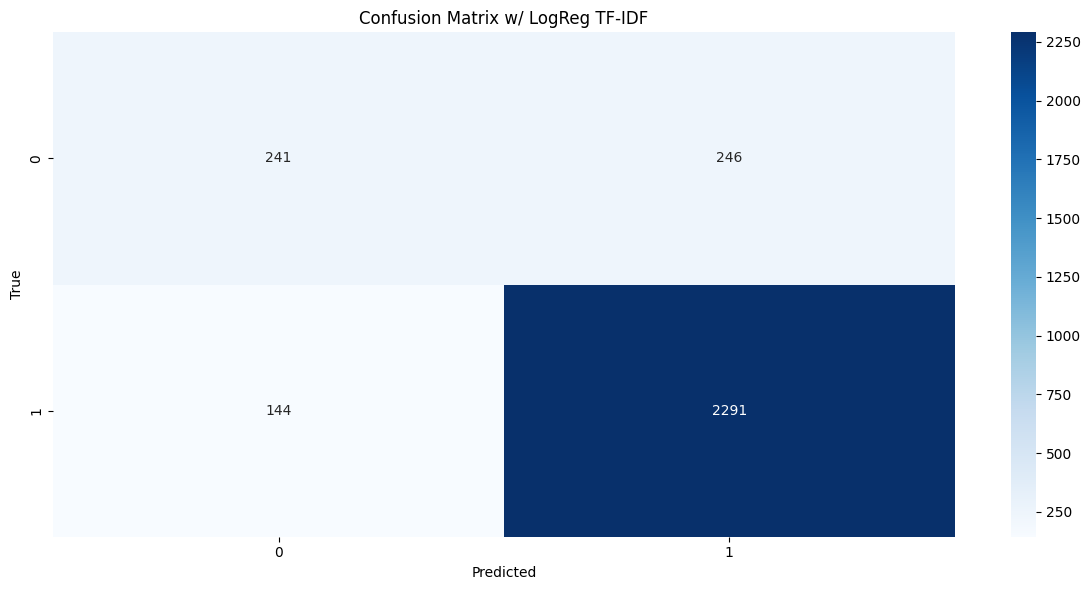

In [21]:
matrix = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ LogReg TF-IDF')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', '6_cm_logreg_tfidf_bin.png'))
plt.show()

<div style="font-size: 20px;"> 

Looking at the confusion matrix, this model has an **higher precision, recall and f1 score** values for the class 0 than the Logreg with the CountVectorizer feature extraction

<br></div>

### RESULTS SAVING
Saving the results to the appropriate folder

In [22]:
save_path = os.path.join(root_path, 'outputs', 'reports', '3_logreg_tfidf.txt')
trainer.save_results(X_test_bin, y_test_bin, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/3_logreg_tfidf.txt


## MULTICLASS CLASSIFICATION TASK

In [23]:
X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

X_train_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)


param_grid = [
    {'solver': ["newton-cg", "lbfgs", "sag"], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'max_iter' : [100000]}
]

### GRIDSEARCH AND TRAINING

In [24]:
trainer = ChunkDevs_GridTrainer(model=model, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_logreg_tfidf_multi = trainer.train(X_train_multi, y_dev_multi)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100000, 'penalty': 'l2', 'solver': 'lbfgs'} 



### TESTING PHASE

In [25]:
y_pred_multi = trainer.predict(X_test_multi)
print(f"Classification report for {str(trainer.model)}")
report = trainer.get_classification_report(X_test_multi, y_test_multi)
print(report)

Classification report for LogisticRegression(random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       487
           1       0.97      0.98      0.97       487
           2       0.90      0.81      0.85       487
           3       0.57      0.59      0.58       487
           4       0.62      0.65      0.64       487
           5       0.95      0.94      0.95       487

    accuracy                           0.82      2922
   macro avg       0.83      0.82      0.82      2922
weighted avg       0.83      0.82      0.82      2922



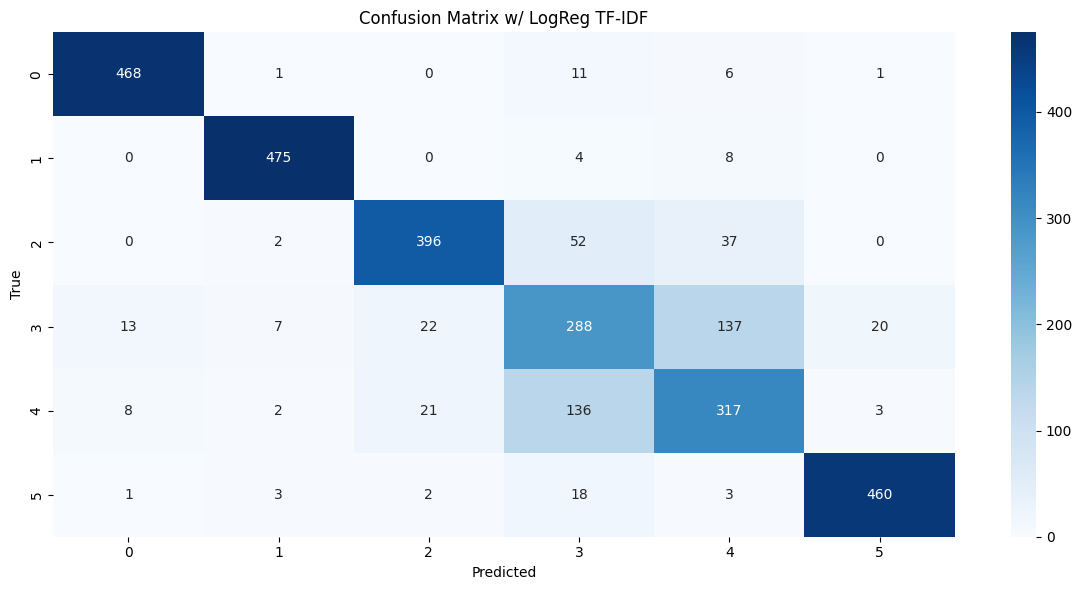

In [26]:
matrix = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ LogReg TF-IDF')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', '7_cm_logreg_tfidf_multi.png'))
plt.show()

<div style="font-size: 20px;">   

However, for the multiclass task, this model has a lower accuracy than the other one

<br></div>


### RESULTS SAVING
Saving the results to the appropriate folder

In [27]:
save_path = os.path.join(root_path, 'outputs', 'reports', '3_logreg_tfidf.txt')
trainer.save_results(X_test_multi, y_test_multi, save_path)

Report saved to /home/m.sanna21/V_HLT/outputs/reports/3_logreg_tfidf.txt


<div style="font-size: 22px;">   

In conclusion, we found that the **logic regression with the Countvectorizer** feature extraction technique is our **strongest baseline for both binary and multiclass classification tasks** , which we will try to surpass while implementing advanced Machine Learning models. 

<br></div>

# MODELS SAVING

Saving the final models to the appropriate folder

In [28]:
# saving of the best models after grid search
handler = ModelHandler(path_models)


models = {
    "logreg_countvect_bin" : best_model_logreg_countvect_bin,
    "logreg_countvect_multi" : best_model_logreg_countvect_multi,
    "logreg_tfidf_bin" : best_model_logreg_tfidf_bin,
    "logreg_tfidf_multi" : best_model_logreg_tfidf_multi
}

handler.save_models(models)

------------------------------------------------------------------------------------------------------
| Save model 'logreg_countvect_bin' to /home/m.sanna21/V_HLT/outputs/models/logreg_countvect_bin.pkl |
------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
| Save model 'logreg_countvect_multi' to /home/m.sanna21/V_HLT/outputs/models/logreg_countvect_multi.pkl |
----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
| Save model 'logreg_tfidf_bin' to /home/m.sanna21/V_HLT/outputs/models/logreg_tfidf_bin.pkl |
----------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------